In [1]:
from fastai.vision.all import *
import torch

**Verify we're using the GPU**

If it fails, this may help:
```
$ sudo rmmod nvidia_uvm
$ sudo rmmod nvidia
$ sudo modprobe nvidia
$ sudo modprobe nvidia_uvm
```

In [2]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'GeForce GTX 1650')

## Replicating the original games

In [3]:
path = Path("/home/yanir/projects/fastai/data/fish-genus")
path.ls()

(#6) [Path('/home/yanir/projects/fastai/data/fish-genus/scarus'),Path('/home/yanir/projects/fastai/data/fish-genus/thalassoma'),Path('/home/yanir/projects/fastai/data/fish-genus/halichoeres'),Path('/home/yanir/projects/fastai/data/fish-genus/other'),Path('/home/yanir/projects/fastai/data/fish-genus/coris'),Path('/home/yanir/projects/fastai/data/fish-genus/ostorhinchus')]

In [4]:
fish_genera = path.ls().map(lambda directory: directory.name)
fish_genera

(#6) ['scarus','thalassoma','halichoeres','other','coris','ostorhinchus']

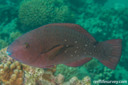

In [5]:
im = Image.open(path / "scarus/scarus-altipinnis-0.jpg")
im.to_thumb(128, 128)

In [6]:
fns = get_image_files(path)
fns

(#719) [Path('/home/yanir/projects/fastai/data/fish-genus/scarus/scarus-dimidiatus-3.jpg'),Path('/home/yanir/projects/fastai/data/fish-genus/scarus/scarus-oviceps-4.jpg'),Path('/home/yanir/projects/fastai/data/fish-genus/scarus/scarus-rivulatus-7.jpg'),Path('/home/yanir/projects/fastai/data/fish-genus/scarus/scarus-iseri-5.jpg'),Path('/home/yanir/projects/fastai/data/fish-genus/scarus/scarus-chameleon-5.jpg'),Path('/home/yanir/projects/fastai/data/fish-genus/scarus/scarus-globiceps-1.jpg'),Path('/home/yanir/projects/fastai/data/fish-genus/scarus/scarus-taeniopterus-5.jpg'),Path('/home/yanir/projects/fastai/data/fish-genus/scarus/scarus-niger-0.jpg'),Path('/home/yanir/projects/fastai/data/fish-genus/scarus/scarus-zelindae-3.jpg'),Path('/home/yanir/projects/fastai/data/fish-genus/scarus/scarus-trispinosus-1.jpg')...]

In [7]:
failed = verify_images(fns)
failed

(#0) []

In [7]:
fish = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128),
)

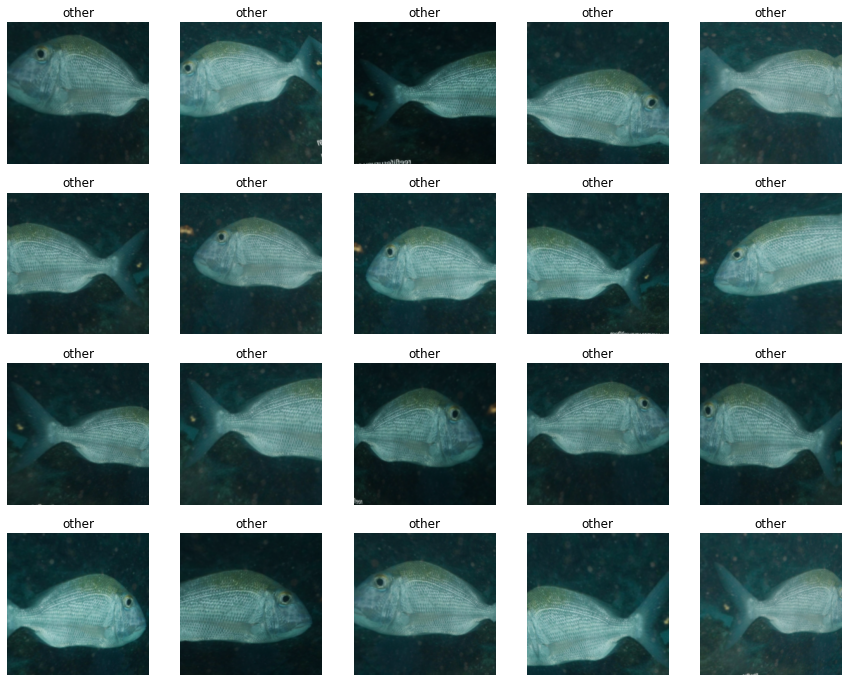

In [17]:
fish = fish.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dls = fish.dataloaders(path)
dls.train.show_batch(max_n=20, nrows=4, unique=True)

In [20]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,2.774950,1.836592,0.608392,00:07


epoch,train_loss,valid_loss,error_rate,time
0,1.822579,1.357942,0.468531,00:07
1,1.731558,1.195530,0.419580,00:07
2,1.478119,1.163670,0.342657,00:07
3,1.301457,1.069214,0.307692,00:07
4,1.126598,1.067094,0.293706,00:07
5,0.991683,1.055328,0.279720,00:07
6,0.864000,1.038160,0.251748,00:07
7,0.765600,1.009364,0.258741,00:07
8,0.677387,0.999072,0.265734,00:07
9,0.606321,1.002123,0.265734,00:07


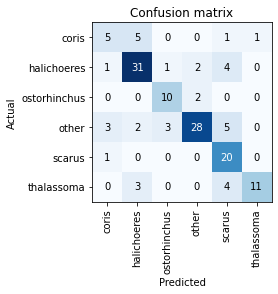

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

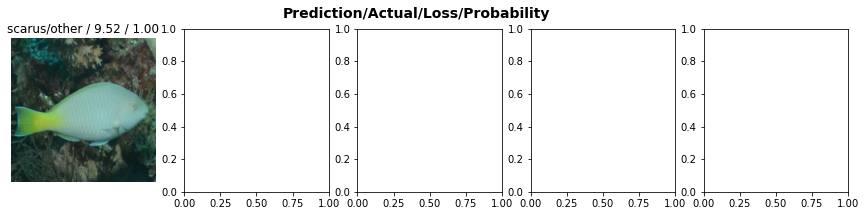

In [30]:
interp.plot_top_losses(5, nrows=1)

In [31]:
interp.print_classification_report()

              precision    recall  f1-score   support

       coris       0.50      0.42      0.45        12
 halichoeres       0.76      0.79      0.77        39
ostorhinchus       0.71      0.83      0.77        12
       other       0.88      0.68      0.77        41
      scarus       0.59      0.95      0.73        21
  thalassoma       0.92      0.61      0.73        18

    accuracy                           0.73       143
   macro avg       0.73      0.72      0.70       143
weighted avg       0.76      0.73      0.73       143



## Doing the same for a species-level dataset

Found 559 items
2 datasets of sizes 448,111
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: RandomResizedCrop -- {'size': (224, 224), 'min_scale': 0.5, 'ratio': (0.75, 1.3333333333333333), 'resamples': (2, 0), 'val_xtra': 0.14, 'max_scale': 1.0, 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}


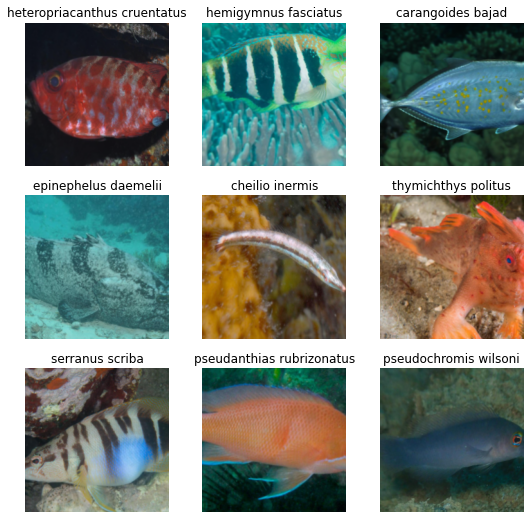

In [4]:
species_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=lambda path: " ".join(path.name.split("-")[:2]),
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms(),
)
dls = species_db.dataloaders(
    Path("/home/yanir/projects/deep-fish/data/rls-species-100-min-images-4"),
    # bs=64,
    verbose=True,
)
dls.show_batch()

In [6]:
resnet18_model = cnn_learner(dls, resnet18, metrics=error_rate)
resnet18_model.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,6.263694,5.063410,0.945946,00:06


epoch,train_loss,valid_loss,error_rate,time
0,5.599988,4.425598,0.936937,00:05
1,5.251786,4.072123,0.855856,00:05
2,4.827985,3.551282,0.792793,00:06
3,4.322864,3.145209,0.756757,00:06
4,3.795102,2.904203,0.675676,00:05
5,3.331970,2.744700,0.630631,00:05
6,2.903902,2.623426,0.612613,00:06
7,2.584702,2.562241,0.567568,00:06
8,2.316092,2.540155,0.576577,00:06
9,2.097601,2.540600,0.576577,00:05


In [7]:
resnet18_model.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.144067,2.495386,0.576577,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.986324,2.479735,0.558559,00:05
1,0.897731,2.358694,0.540541,00:05
2,0.848455,2.271071,0.531532,00:05
3,0.766940,2.238470,0.504505,00:05
4,0.691165,2.207181,0.522523,00:05
5,0.606701,2.155340,0.513514,00:05
6,0.541437,2.131058,0.513514,00:06
7,0.489138,2.135731,0.513514,00:06
8,0.438411,2.133145,0.513514,00:05
9,0.399346,2.136890,0.513514,00:06


In [8]:
resnet34_model = cnn_learner(dls, resnet34, metrics=error_rate)
resnet34_model.fine_tune(20)

epoch,train_loss,valid_loss,error_rate,time
0,6.207296,5.285154,0.972973,00:06


epoch,train_loss,valid_loss,error_rate,time
0,5.579560,4.943582,0.954955,00:07
1,5.238740,4.735981,0.945946,00:08
2,4.899587,4.437640,0.900901,00:08
3,4.526175,4.040833,0.855856,00:08
4,4.084847,3.621795,0.801802,00:07
5,3.600115,3.211300,0.756757,00:07
6,3.140397,2.891510,0.648649,00:08
7,2.723813,2.663255,0.603604,00:08
8,2.352674,2.546985,0.603604,00:09
9,2.037750,2.488807,0.567568,00:08


In [10]:
resnet34_model.fine_tune(20)

epoch,train_loss,valid_loss,error_rate,time
0,0.209100,2.292976,0.558559,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.183414,2.280255,0.540541,00:07
1,0.189675,2.231217,0.549550,00:07
2,0.170557,2.158623,0.522523,00:08
3,0.158532,2.157487,0.504505,00:07
4,0.151670,2.216029,0.486486,00:07
5,0.145384,2.188290,0.477477,00:07
6,0.136605,2.145423,0.459459,00:08
7,0.126522,2.140264,0.477477,00:07
8,0.116316,2.158477,0.486486,00:08
9,0.108010,2.206252,0.477477,00:07


In [5]:
dls_smaller = species_db.dataloaders(Path("/home/yanir/projects/deep-fish/data/rls-species-100-min-images-4"), bs=1)
resnet50_model = cnn_learner(dls_smaller, resnet50, metrics=error_rate)
resnet50_model.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 4096])